## Generating The Turbidity Layer and a Clipping Polygon

In [ ]:
import json
import ee
import geemap

# Initialize Earth Engine, this will have to be a different variable for you
ee.Initialize(project='earthproject145')

# Load polygon from GeoJSON
with open("nile_polygon.geojson", "r") as f:
    geojson_data = json.load(f)

if "coordinates" in geojson_data:
    user_polygon = ee.Geometry.Polygon(geojson_data["coordinates"], geodesic=False)
else:
    raise ValueError("Invalid GeoJSON format: No 'coordinates' key found.")

print("Loaded drawn polygon from 'nile_polygon.geojson'!")

# Function to apply Landsat scaling factors
def apply_scale_factors(image):
    optical_bands = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) \
                         .multiply(0.0000275).add(-0.2)
    return image.addBands(optical_bands, None, True)

# Function to mask clouds and fill SLC gaps
def mask_and_fill(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)
    filled = image.focal_mean(radius=2, units='pixels')
    return filled.updateMask(cloud_mask)

# Load Landsat 7 Data (Filtered, Scaled, Masked, Temporal Composite)
landsat = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
    .filterBounds(user_polygon) \
    .filterDate("2022-12-15", "2023-01-15") \
    .filter(ee.Filter.lt("CLOUD_COVER", 10)) \
    .map(apply_scale_factors) \
    .map(mask_and_fill) \
    .median()

print("Available Bands:", landsat.bandNames().getInfo())

# Compute NDTI (Red & Green) for turbidity
ndti = landsat.normalizedDifference(["SR_B4", "SR_B3"]).rename("NDTI")

# Compute NDWI (Green & NIR) for water mask
ndwi = landsat.normalizedDifference(["SR_B3", "SR_B5"]).rename("NDWI")

# Smooth NDWI with larger radius and apply threshold for water mask
ndwi_smoothed = ndwi.focal_median(radius=3, units='pixels')
ndwi_water_mask = ndwi_smoothed.gt(0.15)

# Apply morphological dilation to fill gaps
ndwi_water_mask = ndwi_water_mask.focal_max(radius=1, units='pixels')

# Clip NDWI mask explicitly with polygon geometry
water_mask_clipped = ndwi_water_mask.clip(user_polygon)

# Apply clipped water mask to NDTI turbidity
ndti_masked = ndti.updateMask(water_mask_clipped)

# Visualization parameters
ndti_vis = {
    "min": -0.3, "max": 0.3,
    "palette": ["blue", "cyan", "yellow", "orange", "red"]
}

# Create Map
Map = geemap.Map(center=[27.0, 31.5], zoom=6)
Map.add_basemap("OpenStreetMap")
Map.addLayer(ndti_masked, ndti_vis, "Turbidity (NDTI)")
Map.addLayer(water_mask_clipped, {"palette": ["cyan"], "opacity": 0.5}, "Water Mask")

# Display Map
display(Map)


Loaded drawn polygon from 'nile_polygon.geojson'!
Available Bands: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_ATMOS_OPACITY', 'SR_CLOUD_QA', 'ST_B6', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']


Map(center=[27.0, 31.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

Turbidity (NDTI) correctly displayed with the NDWI-derived water mask clipped by provided polygon!


In [ ]:
import ee
import json
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize(project='earthproject145')

# Load polygon from GeoJSON
with open("nile_polygon.geojson", "r") as f:
    geojson_data = json.load(f)

user_polygon = ee.Geometry.Polygon(geojson_data["coordinates"], geodesic=False)

# Scaling function
def apply_scale_factors(image):
    optical_bands = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) \
                         .multiply(0.0000275).add(-0.2)
    return image.addBands(optical_bands, None, True)

# Date range for January 2023
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 2, 1)

current_date = start_date
while current_date < end_date:
    next_date = current_date + timedelta(days=1)
    
    # Filter the Landsat image collection for the current day
    landsat_daily = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
        .filterBounds(user_polygon) \
        .filterDate(current_date.strftime('%Y-%m-%d'), next_date.strftime('%Y-%m-%d')) \
        .filter(ee.Filter.lt("CLOUD_COVER", 10)) \
        .map(apply_scale_factors)

    size = landsat_daily.size().getInfo()
    if size > 0:
        # Select the median image for the day if multiple images exist
        daily_image = landsat_daily.median()

        # Compute NDTI
        ndti = daily_image.normalizedDifference(["SR_B4", "SR_B3"]).rename("NDTI")

        # Apply relaxed NDWI water mask
        ndwi = daily_image.normalizedDifference(["SR_B3", "SR_B5"]).rename("NDWI")
        water_mask = ndwi.gt(0).clip(user_polygon)

        # Apply water mask to NDTI
        ndti_masked = ndti.updateMask(water_mask).clip(user_polygon)

        # Export raw NDTI GeoTIFF
        task = ee.batch.Export.image.toDrive(
            image=ndti_masked,
            description=f"Nile_Turbidity_{current_date.strftime('%Y-%m-%d')}",
            folder="Nile_Turbidity_Raw_GeoTIFF",
            fileNamePrefix=f"nile_turbidity_{current_date.strftime('%Y_%m_%d')}",
            region=user_polygon,
            scale=30,
            crs='EPSG:4326',
            maxPixels=1e9,
            fileFormat='GeoTIFF'
        )

        task.start()
        print(f"Initiated raw GeoTIFF export for {current_date.strftime('%Y-%m-%d')}")

    else:
        print(f"No images available for {current_date.strftime('%Y-%m-%d')}")

    current_date = next_date

print("All export tasks initiated. Monitor your Earth Engine tasks and Drive.")


Initiated raw GeoTIFF export for 2023-01-01
No images available for 2023-01-02
No images available for 2023-01-03
No images available for 2023-01-04
No images available for 2023-01-05
Initiated raw GeoTIFF export for 2023-01-06
No images available for 2023-01-07
Initiated raw GeoTIFF export for 2023-01-08
No images available for 2023-01-09
No images available for 2023-01-10
No images available for 2023-01-11
No images available for 2023-01-12
Initiated raw GeoTIFF export for 2023-01-13
No images available for 2023-01-14
No images available for 2023-01-15
No images available for 2023-01-16
No images available for 2023-01-17
Initiated raw GeoTIFF export for 2023-01-18
No images available for 2023-01-19
No images available for 2023-01-20
No images available for 2023-01-21
No images available for 2023-01-22
Initiated raw GeoTIFF export for 2023-01-23
No images available for 2023-01-24
Initiated raw GeoTIFF export for 2023-01-25
No images available for 2023-01-26
No images available for 202

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 12360, 'height': 22304, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 30.561224954916597,
       0.0, -0.00026949458523585647, 29.944621343896955), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


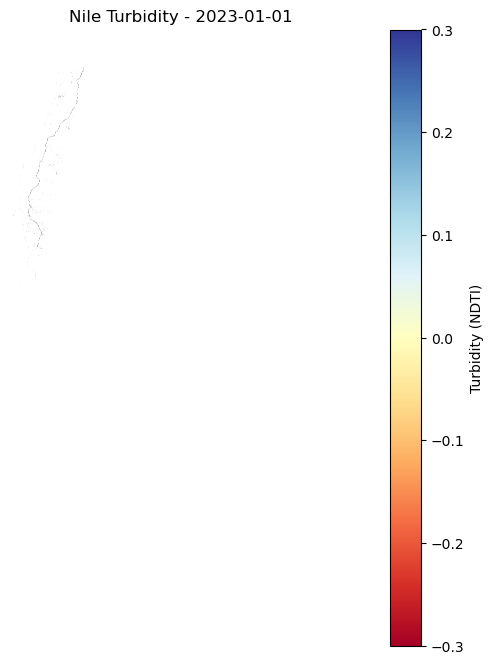

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Path to your GeoTIFF file
tif_path = '/home/user/MSc/Turbidity/Nile_Turbidity_2023_January/nile_turbidity_2023_01_06.tif'

# Open the GeoTIFF file
with rasterio.open(tif_path) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile  # Metadata about the raster
    print(profile)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='RdYlBu', vmin=-0.3, vmax=0.3)
plt.colorbar(label='Turbidity (NDTI)')
plt.axis('off')
plt.show()


## Export GOOD THING, JUST DISPLAYS INCORECTLY

# Displaying .TIF on OpenStreemMap

In [ ]:
import folium
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
from folium.raster_layers import ImageOverlay

# Define the file path 
tif_file = "/home/user/MSc/Turbidity/Nile_Turbidity_Processed/turbidity_ndti_jan_test.tif"

# Load raster data
with rasterio.open(tif_file) as dataset:
    bounds = dataset.bounds
    ndti_array = dataset.read(1)
    crs = dataset.crs

# Ensure correct CRS (EPSG:4326)
if crs.to_epsg() != 4326:
    raise ValueError(f"TIFF is not EPSG:4326. Found: {crs}")

# Define bounding box
min_lon, min_lat, max_lon, max_lat = bounds.left, bounds.bottom, bounds.right, bounds.top

# Create Folium Map centered
m = folium.Map(location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], zoom_start=10)

# Handle NDTI data clearly (mask out zeros/no data)
img_array = np.where(img_array == dataset.nodata, np.nan, img_array)

# Generate clear color visualization directly (using the same palette you had)
plt.figure(figsize=(12, 10))

# Visualize clearly preserving turbidity color gradients
plt.imshow(
    img_array,
    cmap='RdYlBu_r',  # Clear turbidity-friendly colormap
    extent=[min_lon, max_lon, min_lat, max_lat],
    origin='upper',
    vmin=-0.3, vmax=0.3  # Your turbidity visualization range clearly defined
)
plt.axis('off')

# Convert plot to PNG in memory
img_stream = io.BytesIO()
plt.savefig(img_stream, format="png", bbox_inches="tight", pad_inches=0, transparent=True, dpi=300)
plt.close()

# Convert to Base64 for Folium
img_stream.seek(0)
img_base64 = base64.b64encode(img_stream.getvalue()).decode()

# Folium Map Creation
m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=10
)

# Add the Image Overlay
image_overlay = ImageOverlay(
    image=f"data:image/png;base64,{img_base64}",
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    opacity=0.8,
    interactive=True,
    cross_origin=False
)
image_overlay.add_to(m)

# Add Base Layer and Controls
folium.TileLayer("OpenStreetMap").add_to(m)
folium.LayerControl().add_to(m)

# Save map as HTML
map_output = "/home/user/MSc/Turbidity/Nile_Turbidity_Processed/turbidity_map.html"
m.save(map_output)
print(f"[INFO] High-resolution turbidity map saved: {map_output}")

# Optional display in Jupyter
display(m)


RasterioIOError: /home/user/MSc/Turbidity/Nile_Turbidity_Processed/turbidity_ndti_jan_test.tif: No such file or directory

The code downloaded 1999-07-20 and 1999-07-27 combined reprojected data for now, but the revisit interval stated here https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1_L2#bands is 16 days, so how come?

​Landsat 7 operates in a sun-synchronous orbit with a 16-day repeat cycle, meaning it revisits the same location on Earth's surface every 16 days. However, due to the satellite's swath width and orbital path, adjacent paths have an 8-day offset. This configuration allows for overlapping coverage between consecutive orbits, enabling more frequent imaging of certain areas. Consequently, some locations can be imaged every 8 days when they fall within the overlapping regions of adjacent paths. This explains why you have data from both July 20 and July 27, 1999, despite the nominal 16-day revisit interval.​

I was only able to extract 7 .tif files from GEE - January 6th, 8th, 13th, 18th, 23rd, 25th and 30th files. Explain the reason why only these files. Also, mention that 6th day's file is copied and is actually the content of files between january 1st and 6th. January 7th and 8th contains data of 8th. Days between 9th and 13th contain data of january 13th. Days between 14th and 18th contain data for 18th. January 23rd and 24th contain 23rd's data. Days between 25th and 29th contain 25th's data. 30th and 31st contain 30th's data.

I did this because:
Temporal consistency is maintained in the dataset, preventing gaps.
A continuous input dataset is available for the CNN model, even though it's based on repeated values.
The best available data is used, recognizing that satellite-based turbidity retrieval can be highly variable due to environmental conditions.